In [1]:
import glob 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from fastpip import pip
from scipy.signal import savgol_filter    
import scipy
from scipy.optimize import curve_fit

# Preliminar analysis

In this script, I will try to put everything togheder to compute the transition among state ABAB to AAAA obtained by changing the magnetic interaction among particles from purely repulsive to purely attractive. How the magnetic field change in each experiment is explained and computed in script Setting_MagneticField.ipynb. 

In this preliminar analysis I will analyze Experiment 0. This experiment correspond with a purelly attractive interaction. 

To do:

    1. Choose interaction cut off, to separate "train" of particles. 
        Solved: Instead of trains of particles I will analyze pairs of particles.
    2. Develop algorith to define magnetization.
    3. Choose criterium for "density" in trains, the particle-particle distances are not constant.
        Solved: I will choose the mean distance among particles. 
    

## 1. 
The interaction cut off will be obtained from the magnetic susceptibility calculation. At 21 mT the particles reach a maximum distance of approx 70 $\mu m$. The size of the particles is 18.82 $\mu m$.

  <span style="color:red">To do: Take an image of scale bar with 10x Objective!</span>

## 2. 
To do that I need to have the tracking trajectories

    Solved: Trajectories obtained in Script Automatic_Tracking

In [2]:
directory = "/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments"

#filenames = [file for file in glob.glob(
#    os.path.join(directory,('*_tracking.dat')))]
#filenames

In [3]:
# for file_no, filename in enumerate(filenames[0:]):

#     trj = pd.read_csv(filename[:filename.find("_tracking.dat")]+"_tracking.dat", index_col = [0,1], sep ="\t")

In [4]:
name = 'EXP8_2023_03_23_16_23_59'

In [8]:
trj = pd.read_csv(os.path.join(directory,(name+'_tracking.dat')),sep = '\t', usecols = ['frame','particle','x','y'])

In [9]:
n_of_particles = len(trj['particle'].unique())
n_of_particles, trj['particle'].unique()

(16,
 array([  1,  12,  23,  31,  32,  33,  37,  38,  40,  42,  43,  45, 239,
        390, 590, 770]))

# Checking tracking

In [10]:
#trj = trj.query('frame < 1000')

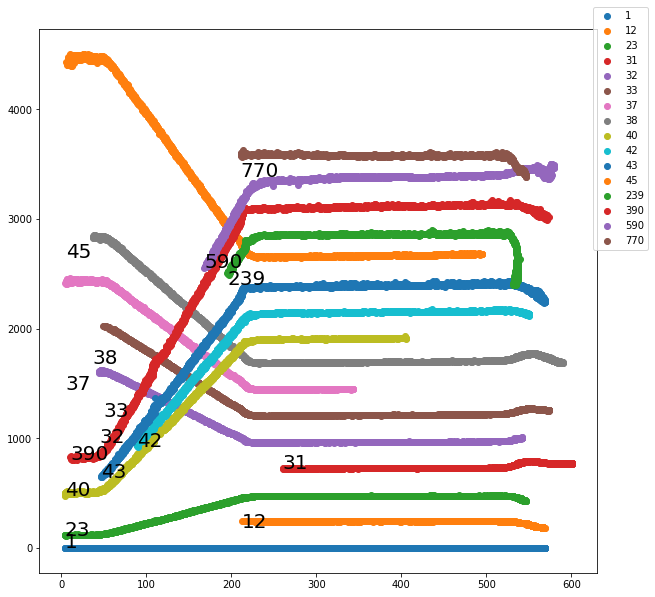

In [11]:
fig, ax = plt.subplots(1, figsize = (10,10))
i = 0
for p, gr in trj.groupby('particle'):
    
    plt.plot(gr.x, gr.y*i, 'o', label = p)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.text(gr.x.min(), gr.y.min()*i, s = str(p), size = 20)
    
    i = i+1

In [24]:
trj = trj[trj.particle != 12] # To drop unuseful particles

# Functions used during analysis

In [25]:
def y_bifurcation_position(df):
    """In this function I will locate the bifurcation position"""
    
    y, x , _ = plt.hist(df['y'], bins = 40, )
    y_bif = x[np.argmax(y)]
    
    return y_bif, df

def x_bifurcation_position(df, y_bif):
    """In this function I will find the x value of the bifurcation"""
    
    particles = df.particle.unique()
    points = []
    for i in particles:
        
        particle = trj.query('particle =='+str(i))

        data = np.stack((particle.x, particle.y), axis=-1)
        points.append(pip(data,4))
    
    points_ar = np.array(points)
    new_df = points_ar.reshape((len(points_ar[0])*len(points_ar),2))
    df = pd.DataFrame(data=new_df, columns = ['x', 'y'])
    y_bifurcation_plus = y_bif+10
    y_bifurcation_minus = y_bif-10

    df_filtered = df.query('y < '+str(y_bifurcation_plus)+' & y > '+str(y_bifurcation_minus))
    x_bif = df_filtered.x.min()
    return x_bif

In [26]:
def improve_x_and_y_bif(trj, x_bif, y_bif):
    
    """This function will improve the first estimation of x_bif and y_bif
        and will return a fit of the channel"""
    x_int = []
    y_int = []
    fit=[]
    
    for i in range(0,len(trj['particle'].unique())):
        
        particle = trj['particle'].unique()[i] # Select a particle trj
        
        print(particle)

        x1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).x
        y1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).y

        x2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).x
        y2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).y
            
        fit1 = np.poly1d(np.polyfit(x1, y1, 1)) # fit biburcation
        fit2 = np.poly1d(np.polyfit(x2, y2, 1)) # fit channel

        fit.append(np.poly1d(np.polyfit(x2, y2, 1))) # fit channel
        # compute intersection among fits
        x_int.append((fit2[0]-fit1[0])/(fit1[1]-fit2[1]))
        y_int.append(fit1[1]*x_int[i]+fit1[0])
        
    x_int = np.mean(x_int)
    y_int = np.mean(y_int)
    
    return x_int, y_int, fit

In [27]:
def up_or_down(df, y_bif):
    
    """This function indicates which channel the particle has choose.
    The information is stored in the column bif."""
    
    df_trj = df[df.duplicated(subset=['frame'], keep=False)]  # Keep only frames that have more than one particle

    df_trj['bif'] = np.NaN
    for p,df in df_trj.groupby('particle'):
        
        if df.iloc[-1].y > y_bif:
            df_trj.loc[trj.particle==p,'bif'] = 'UP'
        else:
            df_trj.loc[trj.particle==p,'bif']= 'DOWN'
        
    return df_trj

In [28]:
def create_pairs(df, frame):
    """This function generates pair of particles. A pair of particle is defined 
    when one particles enter to the channel after the other. So, consecutive
    particles will be part of a pair.
    This function works for one frame"""

    df_f = df.query('frame == '+str(frame)) # First select a frame

    df_order = df_f.sort_values(by = ['x'])       # Order the x column in ascendent values, 
                                                  # this will be the order of particles entering the chanel. 
    new_df = []
    keys = []
    p1 = []
    p2 = []
    j = 2
    
    for i in range(0, len(df_order)-1):       
        
        p1.append(df_order.iloc[i:j].particle.values[0])
        p1.append(df_order.iloc[i:j].particle.values[0])


        p2.append(df_order.iloc[i:j].particle.values[1])
        p2.append(df_order.iloc[i:j].particle.values[1])

        new_df.append(df_order.iloc[i:j])  # Join consecutive rows, generating pairs
      

        keys.append(i)
        j = j +1
    p1 = pd.DataFrame({'p1':p1})
    p2 = pd.DataFrame({'p2':p2})

    final_df = pd.concat(new_df, keys = keys, names = ['pairs','index'])
    pairs = pd.concat([p1,p2], axis = 1)
    
    final_df['p1'] = pairs['p1'].values
    final_df['p2'] = pairs['p2'].values
    
    return final_df

In [29]:
def magnetization(df, frame):
    
    """Magnetization is equal to 1 when the 2 particles choose the same channel
        Magnetization is equal to 0 when the particles choose different channels"""
    
    df = df.query('frame == '+str(frame))
    magnetization = []
    for ind,group in df.groupby(['pairs']):

        if len(np.unique(group.bif)) == 2:

            magnetization.append(0)
            magnetization.append(0)

        else:

            magnetization.append(1) 
            magnetization.append(1)


    df['magnetization'] = magnetization
    return df

In [30]:
def d(df , pix = float, um = float):  
    "With this function I will compute the distance among particles."
    
    df['distance'] = np.NaN # Crate new column
    dx = []
    dy = []
    grouped = df.groupby(['frame','pairs'])
    for name,group in grouped:
        
        dx.append((np.sqrt((group.x.diff(periods=-1).values)**2)[0])*(um/pix))
        dx.append((np.sqrt((group.x.diff(periods=-1).values)**2)[0])*(um/pix))
    
        dy.append((np.sqrt((group.y.diff(periods=-1).values)**2)[0])*(um/pix))
        dy.append((np.sqrt((group.y.diff(periods=-1).values)**2)[0])*(um/pix))
    
    df['dx'] = dx
    df['dy'] = dy
    
    return df

In [31]:
def check_analysis(trj_initial,last_df_analyzed):
    
    n_of_particles = len(trj_initial['particle'].unique())
    n_of_pairs = len(last_df_analyzed.groupby(['p1','p2']).size())
    
    if (n_of_particles == n_of_pairs+1):
        
        print("Analysis succesfully performed of video")
    else:
        print("Something was wrong during tracking or analysis. We detect N partcles and not N-1 pairs")

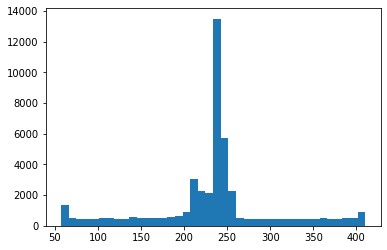

In [32]:
y_bif, df = y_bifurcation_position(trj)
x_bif = x_bifurcation_position(trj, y_bif)

In [33]:
x_bif

210.5237741456166

In [34]:
x_bif, y_bif, fit = improve_x_and_y_bif(trj, x_bif, y_bif)


1
23
32
33
37
38
40
42
43
45
239
390
590


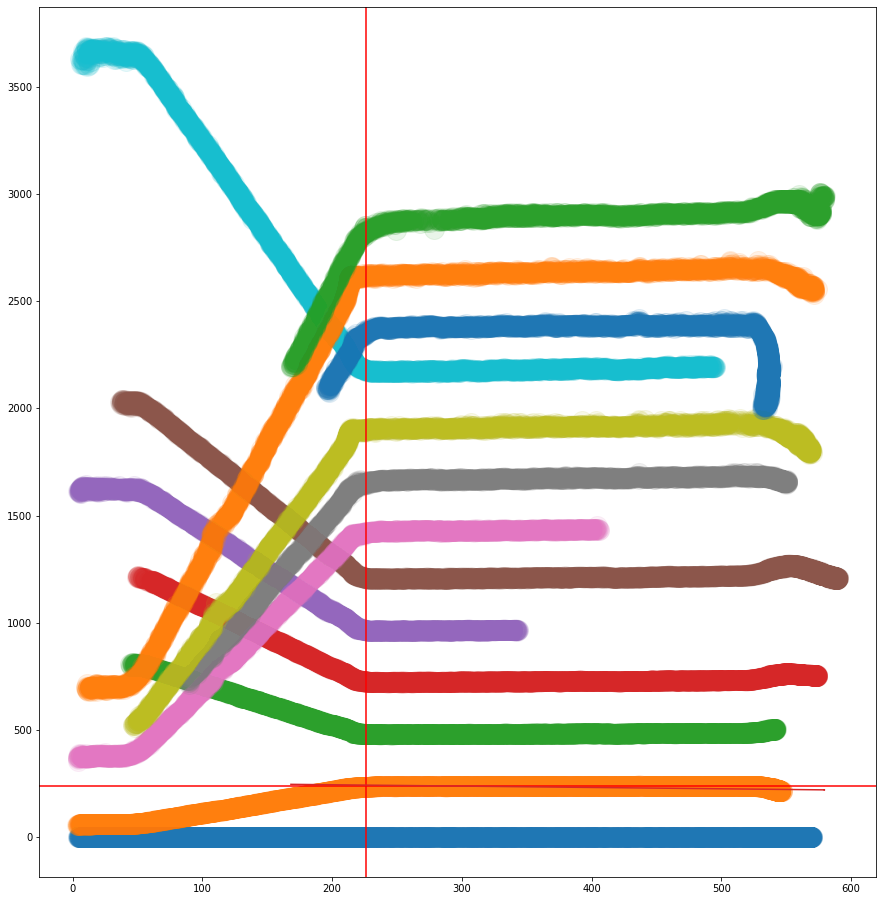

In [35]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in trj.groupby("particle"):
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [36]:
fit

[poly1d([-6.27056826e-02,  2.57356947e+02]),
 poly1d([-3.10579977e-02,  2.46889669e+02]),
 poly1d([1.09918732e-02, 2.38862837e+02]),
 poly1d([3.26795664e-02, 2.32821514e+02]),
 poly1d([-3.97690100e-02,  2.53317177e+02]),
 poly1d([1.58192758e-02, 2.38394415e+02]),
 poly1d([2.47197354e-02, 2.30315604e+02]),
 poly1d([1.02926645e-02, 2.34451122e+02]),
 poly1d([-1.58561361e-02,  2.42648810e+02]),
 poly1d([-2.72007926e-03,  2.43914305e+02]),
 poly1d([-8.41878327e-02,  2.62363167e+02]),
 poly1d([5.74161336e-04, 2.37825739e+02]),
 poly1d([2.66149459e-02, 2.30517194e+02])]

In [37]:
inter = up_or_down(trj,y_bif)

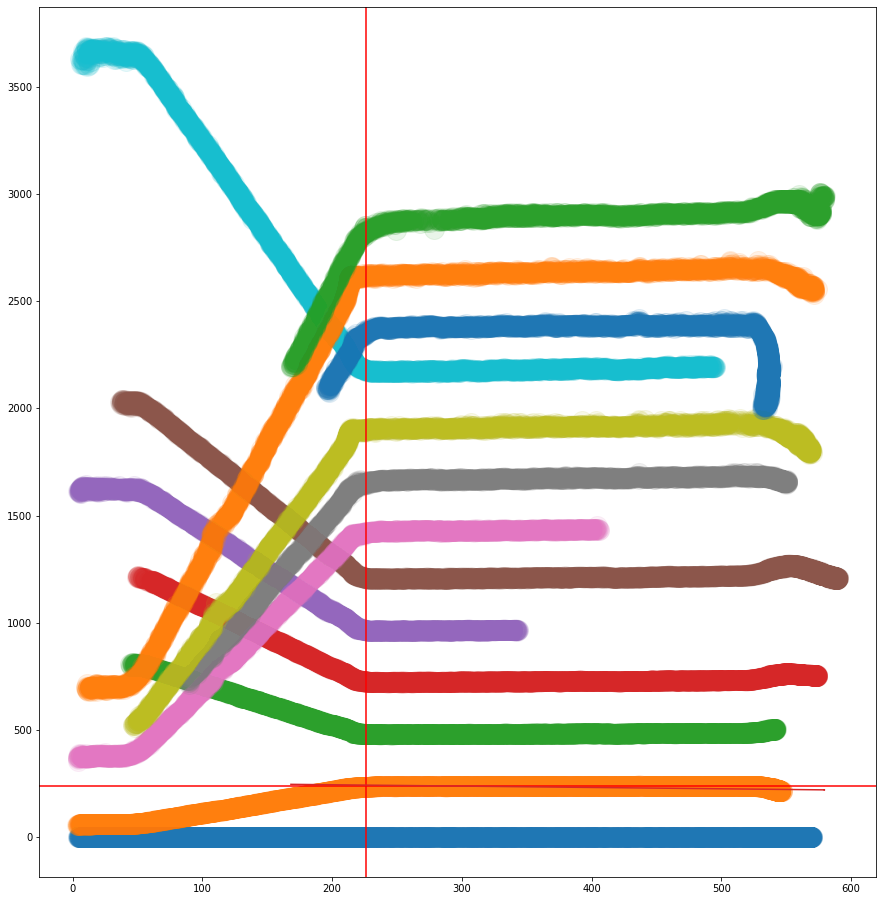

In [38]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in inter.groupby("particle"):
    
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [39]:
len(trj), len(inter)

(47127, 47127)

In [40]:
df_x = inter.query('x > '+str(x_bif))
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

In [41]:
len(df_x), len(df_d)

(25167, 24825)

1
23
32
33
37
38
40
42
43
45
239
390
590


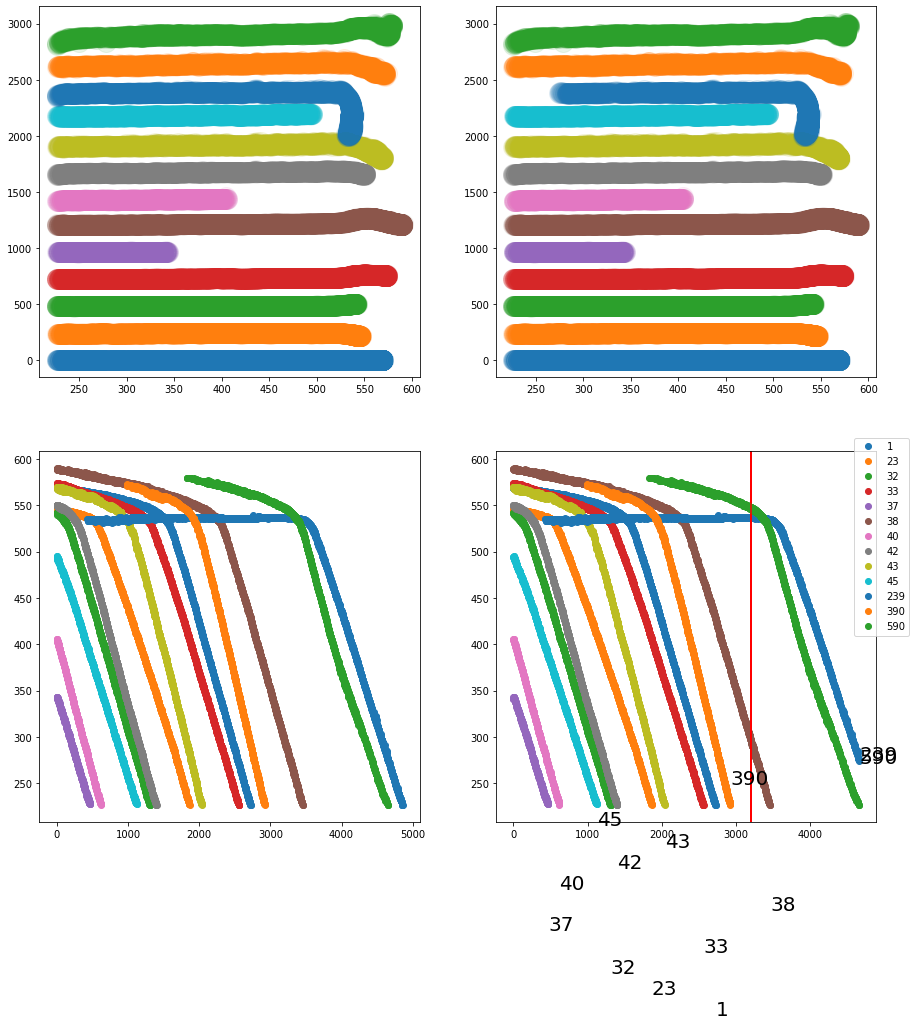

In [42]:
fig, (ax0,ax1) = plt.subplots(2,2, figsize = (15,15))

j = 0
for p,trj_p in df_x.groupby("particle"):
    
    ax0[0].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[0].plot(trj_p.frame, trj_p.x, 'o')
    j = j+1
    
j = 0
for p,trj_p in df_d.groupby("particle"):
    
    ax0[1].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[1].plot(trj_p.frame, trj_p.x, 'o', label = str(p))
    ax1[1].text(trj_p.frame.max(), trj_p.x.min()*0.1*j , s = str(p), size = 20)
    ax1[1].axvline(x=3200, color='r', linestyle='-')
    ax1[1].legend(bbox_to_anchor=(1.1, 1.05))


    print(str(p))

    

    j = j+1

In [43]:
df_d.query('frame == 3200')

,frame,particle,y,x,bif
42141,3200,239,220.337622,536.834505,DOWN
42149,3200,590,246.316020,547.697883,DOWN
42150,3200,38,241.842709,295.235793,UP


In [44]:
%%time
df_last = []

df_x = inter.query('x > '+str(x_bif)+'& x < 500')
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

for frame in df_d['frame'].unique(): # Do analysis frame by frame
    
    pairs = create_pairs(df_d, frame)
    mag = magnetization(pairs, frame)
    df_last.append(d(mag, 1, 1)) # I need to introduce the pix/um conversion.

    
last = pd.concat(df_last)    

CPU times: user 42.5 s, sys: 693 ms, total: 43.2 s
Wall time: 42.4 s


In [45]:
check_analysis(trj, last)

Something was wrong during tracking or analysis. We detect N partcles and not N-1 pairs


In [46]:
n_of_particles

16

In [48]:
last.groupby(['p1','p2']).size() 

p1   p2 
1    390    1292
23   43     1438
32   42     1772
33   1      1696
37   40      936
40   45     1240
42   23     1366
43   33     1150
45   32     1696
390  38      972
590  239    1592
dtype: int64

In [46]:
#last = last[last.p1 != 2] # To drop unuseful particles

In [50]:
last1 = last1[(last1.p1 != 1399)]
last1.groupby(['p1','p2']).size() 

p1    p2  
26    2185    1528
40    1399    1948
41    48      1418
43    44      1144
44    41      1652
45    43      1014
46    45        92
47    1116    1864
49    26      1128
50    740      180
55    40      1034
740   811     2382
775   47      1694
1680  1756    1280
1756  49      1462
dtype: int64

In [69]:
last = last.query('p1 == 590 & p2 == 239')


In [55]:
last1.groupby(['p1','p2']).size() 

p1   p2 
1    390    1060
23   43     1204
32   42     1534
33   1      1452
37   40      680
38   770     340
40   45     1016
42   23     1116
43   33      954
45   32     1432
390  38      772
770  12     1896
dtype: int64

In [123]:
last.groupby(['p1','p2']).size()

p1    p2  
26    2185    1528
40    1399    1948
41    48      1418
43    44      1144
44    41      1652
45    43      1014
46    45        92
47    1116    1864
48    50      1826
      740       12
49    26      1128
50    740      180
55    40      1034
740   811     2382
775   47      1694
811   47        54
      775     2550
1116  40       122
      55      1954
1399  1680    1266
      1756     286
1680  1756    1280
1756  49      1462
dtype: int64

In [49]:
last.groupby(['p1','p2']).size() 

p1  p2
13  37    1914
dtype: int64

In [142]:
last1 = last[(last['p1'] == 1399) & (last['p2'] == 1680)]
last1.groupby(['p1','p2']).size() 

p1    p2  
1399  1680    1266
dtype: int64

# Next step

Now I need to compute the main distance in the channel for pairs of particles and associate a magnetization value to this pair.

In [49]:
def distance_and_magnetization(df, x_bif):
    
    output = df.groupby(['p1','p2']).mean()
    output['dx_err'] = df.groupby(['p1','p2']).dx.std()/np.sqrt(df.groupby(['p1','p2']).count()['dx'])
    output['dy_err'] = df.groupby(['p1','p2']).dy.std()/np.sqrt(df.groupby(['p1','p2']).count()['dy'])

    
    return output

In [52]:
output = distance_and_magnetization(last,x_bif)
output

,,frame,particle,y,x,magnetization,distance,dx,dy,dx_err,dy_err
p1,p2,,,,,,,,,,
1,390,2397.506192,195.5,239.006317,355.698225,1.0,NaN,83.371383,1.770577,0.272190,0.019846
23,43,1504.001391,33.0,238.897013,355.531481,1.0,NaN,74.050312,1.516916,0.313984,0.023208
32,42,865.514673,37.0,240.330240,359.214502,0.0,NaN,31.051770,2.340401,0.113549,0.013579
33,1,2132.524764,17.0,240.393630,360.979548,0.0,NaN,50.893398,3.640340,0.098512,0.014191
37,40,233.506410,38.5,239.976841,311.824602,0.0,NaN,52.411693,2.490720,0.174317,0.017707
40,45,309.506452,42.5,240.762819,370.650930,0.0,NaN,109.469648,4.488354,0.287813,0.015571
42,23,1058.021962,32.5,238.691581,372.003020,1.0,NaN,104.540877,0.595873,0.290925,0.012770
43,33,1748.006957,38.0,241.034838,375.060049,0.0,NaN,115.133412,4.213049,0.339050,0.021548
45,32,699.500000,38.5,241.990682,359.275796,1.0,NaN,57.186535,0.469697,0.134485,0.008715


In [53]:
output.to_csv('magnetization_'+name+'.dat', sep = '\t')